In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def train(inputDataLoader,model,loss_function,optimizer):
    
    model.train()
    acccs=[]
    loss_array=[]
    for (inputs,label) in inputDataLoader:
        label=label.to(device)
        inputs = inputs.reshape(-1, 28*28).to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(loss.detach().cpu().numpy())
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        # measure accuracy and record loss
        acc1 = accuracy(preds, labels)
        acccs.append(acc1)
    return np.mean(acccs),np.mean(loss_array)

In [6]:
def test(inputDataLoader,model,loss_function,optimizer):
    model.eval()
    output_result=[]
    loss_array=[]
    acccs=[]
    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            inputs = inputs.reshape(-1, 28*28).to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            loss_array.append(loss.detach().cpu().numpy())
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            # measure accuracy and record loss
            acc1 = accuracy(preds, labels)
            acccs.append(acc1)
    return np.mean(acccs),np.mean(loss_array)

In [7]:
class NeuralNet(torch.nn.Module):

    def __init__(self,input_size,hidden_layer_size,output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.activ1=nn.ReLU()
        self.fc2 = nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size) 
        self.activ2=nn.ReLU()
        self.fc3 = nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size)    
        self.activ3=nn.ReLU()
        self.fc4 = nn.Linear(in_features=hidden_layer_size, out_features=output_size)  
                                                                
    def forward(self, x):
        x = self.fc1(x)   
        x = self.activ1(x)
        x = self.fc2(x)        
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        return x 

In [8]:
def initMNIST(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [9]:
training_acc_data=[]
testing_acc_data=[]
training_loss_data=[]
testing_loss_data=[]
hidden_layer_list=[450,500,550,600,640,700,800,900,1000,1280]
epochs=10
parameter_list=[]
train_loader,test_loader=initMNIST(256,256)
for parameter in hidden_layer_list:
    training_acc=[]
    testing_acc=[]
    training_loss=[]
    testing_loss=[]
    model=NeuralNet(784,parameter,10)
    model.to(device)
    optimizer=optim.Adam(model.parameters(),lr=1e-3)
    loss_func=nn.CrossEntropyLoss()
    for epoch in tqdm(range(0,epochs,1)):
        train_acc,train_loss=train(train_loader,model,loss_func,optimizer)
        test_acc,test_loss=test(test_loader,model,loss_func,optimizer)
        training_acc.append(train_acc)
        testing_acc.append(test_acc)
        training_loss.append(train_loss)
        testing_loss.append(test_loss)
    
    number_of_parameters= parameter_list.append(count_parameters(model))
    testing_acc_data.append(np.mean(testing_acc))
    training_acc_data.append(np.mean(training_acc))
    training_loss_data.append(np.mean(training_loss))
    testing_loss_data.append(np.mean(testing_loss))


100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


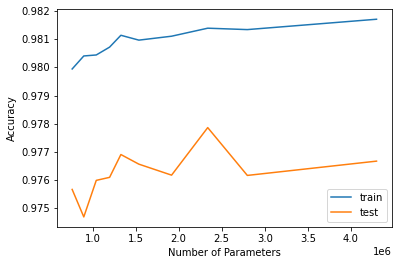

In [10]:
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.plot(parameter_list,training_acc_data,label="train")
plt.plot(parameter_list,testing_acc_data,label="test")
plt.legend()
plt.savefig("3.2_acc.png")



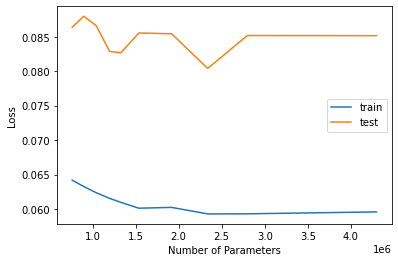

In [11]:
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.plot(parameter_list,training_loss_data,label="train")
plt.plot(parameter_list,testing_loss_data,label="test")
plt.legend()
plt.savefig("3.2_loss.png")



In [12]:

# x, y = zip(*training_acc_data)
# y = np.array(y)
# x1,y1=zip(*testing_acc_data)
# y1=np.array(y1)
# plt.xlabel('Number of Parameters')
# plt.ylabel('Accuracy')
# plt.scatter(np.repeat(x, y.shape[1]), np.mean(y.flat),label="Training")
# plt.scatter(np.repeat(x1, y1.shape[1]), np.mean(y1.flat),label="Testing")
# plt.legend()
# plt.savefig("3.2_acc.png")

In [13]:

# x, y = zip(*training_loss_data)
# # y = np.array(y)
# x1,y1=zip(*testing_loss_data)
# y1=np.array(y1)
# plt.xlabel('Number of Parameters')
# plt.ylabel('Loss')
# plt.scatter(np.repeat(x, y.shape[1]), y.flat,label="Training")
# plt.scatter(np.repeat(x1, y1.shape[1]), y1.flat,label="Testing")
# plt.legend()
# plt.savefig("3.2_loss.png")